# Create a table of COSMIC profile file names, times and dates, and locations

Author: Brian Green (briangre@stanford.edu)

In [1]:
import pycwt as wavelet
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
import pandas as pd
from dataclasses import dataclass
import warnings
from scipy.ndimage import label
from scipy.stats import chi2
from scipy import interpolate
warnings.simplefilter("ignore")

import xarray as xr
import dask
import os

### Load in a sample profile to see what's in it

<xarray.Dataset>
Dimensions:        (MSL_alt: 2798, OL_par: 20, OL_vec: 5749)
Coordinates:
  * MSL_alt        (MSL_alt) float32 59.98 59.96 59.94 ... 2.764 2.742 2.72
  * OL_par         (OL_par) float64 nan nan nan nan nan ... nan nan nan nan nan
Dimensions without coordinates: OL_vec
Data variables: (12/16)
    Lat            (MSL_alt) float32 -14.63 -14.63 -14.63 ... -13.12 -13.11
    Lon            (MSL_alt) float32 -110.1 -110.1 -110.1 ... -109.8 -109.8
    Ref            (MSL_alt) float32 ...
    Azim           (MSL_alt) float32 ...
    Pres           (MSL_alt) float32 0.2109 0.2115 0.212 ... 741.3 743.3 745.3
    Temp           (MSL_alt) float32 -19.03 -18.94 -18.85 ... 3.666 3.979 4.309
    ...             ...
    Bend_ang_conf  (MSL_alt) float64 ...
    OL_ipar        (OL_par) float64 ...
    OL_vec1        (OL_vec) float64 ...
    OL_vec2        (OL_vec) float64 ...
    OL_vec3        (OL_vec) float64 ...
    OL_vec4        (OL_vec) float64 ...
Attributes: (12/80)
    occ_id:            1
    fiducial_id:       
    reference_sat_id:  6
    occulting_sat_id:  21
    year:              2014
    month:             1
    ...                ...
    fileStamp:         C001.2014.001.00.03.G21
    inverter:          newroam
    parmsfile:         parms1
    center:            UCAR/CDAAC
    bad:               0
    errstr:

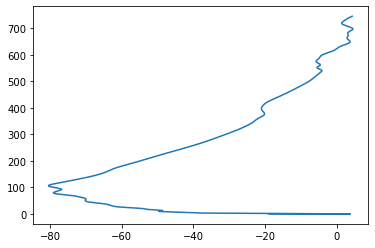

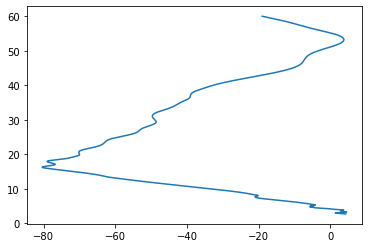

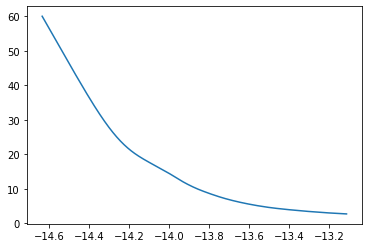

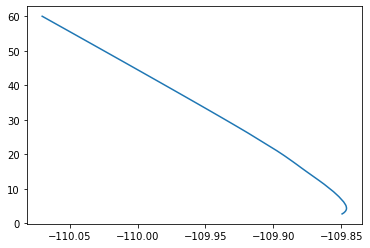

In [2]:
data = xr.open_dataset('temp_data/atmPrf_C001.2014.001.00.03.G21_2013.3520_nc')

plt.figure()
plt.plot(data.Temp, data.Pres)

plt.figure()
plt.plot(data.Temp, data.MSL_alt)

plt.figure()
plt.plot(data.Lat, data.MSL_alt)

plt.figure()
plt.plot(data.Lon, data.MSL_alt)

data

### Make a list of each COSMIC file name, the date of the scan, and the average scan latitude and longitude between 16 and 21km altitude.

File read errors are usually associated with the presence of a file called .DS_Store; make sure these are deleted from all subdirectories before running.

In [4]:
# Path to the COSMIC data, and initialize the table
path = '/Users/briangre/Documents/gravity_waves/cosmic2_data/atmPrf'
cosmic_list = pd.DataFrame(columns=['Name','Lat','Lon','Year','DOY','Hour','Minute','Day','Month'])

# Indices for converting the day-of-year (DOY) to Month, Day format
temp = np.array([31,28,31,30,31,30,31,31,30,31,30,31]) # days in each month
months = 1 + np.arange(12)
days = np.ones(12)
days[1:] = days[1:] + np.cumsum(temp[:-1]) # DOY of the first of each month

# Each file name contains the year, DOY, hour, and minute;
# read these values. Also load in the latitude and longitude profiles and
# average them between 16 and 21km altitude.
for root, directories, files in os.walk(path, topdown=True):
    print(root)
    for name in files:
        temp_data = xr.open_dataset(os.path.join(root, name))
        # Handle quantities that are integers (Year, DOY, Minute, Hour) here.
        temp = pd.DataFrame(np.array([[np.int(name[12:16]), np.int(name[17:20]),
                            np.int(name[24:26]), np.int(name[21:23]), 0, 0, 0, 0, 0]]),
                            columns=['Year', 'DOY', 'Minute', 'Hour', 'Name',
                                     'Lat', 'Lon', 'Day', 'Month'])
        # Handle quantities that aren't integers (Name, Lat, Lon) here.
        temp.Name = os.path.join(root, name)
        ind1 = np.where(np.abs(temp_data.MSL_alt - 16) == np.min(np.abs(temp_data.MSL_alt - 16)))[0] # index of 16km data point
        ind2 = np.where(np.abs(temp_data.MSL_alt - 21) == np.min(np.abs(temp_data.MSL_alt - 21)))[0] # index of 21km data point
        ind1 = int(np.min(ind1))
        ind2 = int(np.min(ind2))
        temp.Lat = float(temp_data.Lat[np.min([ind1,ind2]):np.max([ind1,ind2])].mean())
        temp.Lon = float(temp_data.Lon[np.min([ind1,ind2]):np.max([ind1,ind2])].mean())
        
        # Convert DOY to Month and Day
        if np.remainder(np.int(name[12:16]),4) == 0: # leap year
            days_temp = days.copy()
            days_temp[2:] = days_temp[2:] + 1 # increase the DOY indexing starting March 1
            days_temp = np.int(name[17:20]) - days_temp
            days_temp[days_temp < 0] = days_temp[days_temp < 0] + 1000
            temp.Day = 1 + np.int(np.min(days_temp))
            temp.Month = months[days_temp == np.min(days_temp)]
        else:
            days_temp = np.int(name[17:20]) - days
            days_temp[days_temp < 0] = days_temp[days_temp < 0] + 1000
            temp.Day = 1 + np.int(np.min(days_temp))
            temp.Month = months[days_temp == np.min(days_temp)]
        
        # Append
        cosmic_list = cosmic_list.append(temp, ignore_index=True)

# Convert the year-month-day-hour-minute data to one date value.
cosmic_list['Date'] = pd.to_datetime(cosmic_list[['Year','Month','Day','Hour','Minute']], format='%Y%m%d%h%m')

# Delete the unnecessary time columns and save the list
cosmic_list = cosmic_list.drop(columns=['DOY','Hour','Minute','Day','Month','Year'])
cosmic_list.to_feather('temp_data/cosmic2_list_2021_76-134.feather')
cosmic_list

/Users/briangre/Documents/gravity_waves/cosmic2_data/atmPrf
/Users/briangre/Documents/gravity_waves/cosmic2_data/atmPrf/2021
/Users/briangre/Documents/gravity_waves/cosmic2_data/atmPrf/2021/132
/Users/briangre/Documents/gravity_waves/cosmic2_data/atmPrf/2021/104
/Users/briangre/Documents/gravity_waves/cosmic2_data/atmPrf/2021/103
/Users/briangre/Documents/gravity_waves/cosmic2_data/atmPrf/2021/102
/Users/briangre/Documents/gravity_waves/cosmic2_data/atmPrf/2021/105
/Users/briangre/Documents/gravity_waves/cosmic2_data/atmPrf/2021/133
/Users/briangre/Documents/gravity_waves/cosmic2_data/atmPrf/2021/134
/Users/briangre/Documents/gravity_waves/cosmic2_data/atmPrf/2021/079
/Users/briangre/Documents/gravity_waves/cosmic2_data/atmPrf/2021/077
/Users/briangre/Documents/gravity_waves/cosmic2_data/atmPrf/2021/083
/Users/briangre/Documents/gravity_waves/cosmic2_data/atmPrf/2021/084
/Users/briangre/Documents/gravity_waves/cosmic2_data/atmPrf/2021/085
/Users/briangre/Documents/gravity_waves/cosmic2

,Name,Lat,Lon,Date
0,/Users/briangre/Documents/gravity_waves/cosmic...,-3.230354,-63.568726,2021-05-12 19:02:00
1,/Users/briangre/Documents/gravity_waves/cosmic...,11.619181,133.404388,2021-05-12 05:35:00
2,/Users/briangre/Documents/gravity_waves/cosmic...,-5.746995,57.529510,2021-05-12 03:02:00
3,/Users/briangre/Documents/gravity_waves/cosmic...,21.141041,123.769539,2021-05-12 10:03:00
4,/Users/briangre/Documents/gravity_waves/cosmic...,9.384144,132.992828,2021-05-12 10:13:00
...,...,...,...,...
292879,/Users/briangre/Documents/gravity_waves/cosmic...,-28.749231,126.965569,2021-04-23 20:14:00
292880,/Users/briangre/Documents/gravity_waves/cosmic...,4.198847,-179.223648,2021-04-23 23:23:00
292881,/Users/briangre/Documents/gravity_waves/cosmic...,-6.399819,-2.042334,2021-04-23 06:18:00
292882,/Users/briangre/Documents/gravity_waves/cosmic...,-23.871614,116.734634,2021-04-23 18:11:00


### Join up the different lists into one large list and save

In [4]:
temp1 = pd.read_feather('temp_data/cosmic1_list_2011-2013.feather')
temp2 = pd.read_feather('temp_data/cosmic1_list_2014-2019.feather')
temp3 = pd.read_feather('temp_data/cosmic2_list_2019.feather')
temp4 = pd.read_feather('temp_data/cosmic2_list_2020_1-202.feather')
temp5 = pd.read_feather('temp_data/cosmic2_list_2020_203-366.feather')
temp6 = pd.read_feather('temp_data/cosmic2_list_2021_1-50.feather')
temp7 = pd.read_feather('temp_data/cosmic2_list_2021_51-75.feather')
temp8 = pd.read_feather('temp_data/cosmic2_list_2021_76-134.feather')
frames = [temp1, temp2, temp3, temp4, temp5, temp6, temp7, temp8]
temp = pd.concat(frames, ignore_index = True)

## Some of this was done in a temp folder; fix the path
#temp.Name = temp.Name.str.replace('/temp/', '/', regex=True)

temp.to_feather('temp_data/3a_cosmic_list.feather')
temp

,Name,Lat,Lon,Date
0,/Users/briangre/Documents/gravity_waves/cosmic...,48.838894,-20.548496,2013-05-15 17:32:00
1,/Users/briangre/Documents/gravity_waves/cosmic...,-43.159657,-77.366478,2013-05-15 11:56:00
2,/Users/briangre/Documents/gravity_waves/cosmic...,23.364857,-28.325857,2013-05-15 14:35:00
3,/Users/briangre/Documents/gravity_waves/cosmic...,55.125278,45.992245,2013-05-15 02:41:00
4,/Users/briangre/Documents/gravity_waves/cosmic...,67.952621,-149.315048,2013-05-15 23:17:00
...,...,...,...,...
5632346,/Users/briangre/Documents/gravity_waves/cosmic...,-28.749231,126.965569,2021-04-23 20:14:00
5632347,/Users/briangre/Documents/gravity_waves/cosmic...,4.198847,-179.223648,2021-04-23 23:23:00
5632348,/Users/briangre/Documents/gravity_waves/cosmic...,-6.399819,-2.042334,2021-04-23 06:18:00
5632349,/Users/briangre/Documents/gravity_waves/cosmic...,-23.871614,116.734634,2021-04-23 18:11:00
